In [2]:
import pygmt
import numpy as np
import os
import pandas as pd
from pyrocko import util, model, io, trace, gmtpy
import pyrocko.moment_tensor as pmt
from pyrocko.plot import beachball
import matplotlib.pyplot as plt

workdir='../'
catdir =  os.path.join(workdir,'CAT')

switch_VLP=True         ###SWITCH###

if switch_VLP:
    clustydir='../../clusty_flegrei/results_VLP'    
else:
    clustydir='../../clusty_flegrei/results_VT'   

clusty_filename= os.path.join(clustydir,'cat_trimmed_mean_ccs_dbscan_comb_0.150_3.yaml')  ###CHANGE###
           
clusty_events = model.load_events(clusty_filename)

### Open clusty results

In [2]:
cluster_number=[]
cluster_color=[]
for ev in clusty_events:
    if not ev.extras['cluster_number'] in cluster_number:
        cluster_number.append(ev.extras['cluster_number'])
        cluster_color.append(ev)

cls = {key: [] for key in cluster_number}
for ev in clusty_events:
    cls[ev.extras['cluster_number']].append(ev.moment_tensor)

cls_color = {key: [] for key in cluster_number}
for color in cluster_color:
    cls_color[color.extras['cluster_number']].append(color.extras['color'])

if not switch_VLP:
    del cls[-1]     #remove ev not clustered, only for VT
    del cls_color[-1]

for key in cls:
    print(f'cluster {key} with n ev = {len(cls[key])}')
    print(f'cluster {key} with color {cls_color[key]}\n')

cluster 0 with n ev = 12
cluster 0 with color ['#00A08B']



### KAGAN moment tensor for each cluster VT

In [40]:
switch_calculate_kagan=False                            ###SWITCH###                       

if switch_calculate_kagan:

    cls_ev = {key: [] for key in cluster_number}
    for ev in clusty_events:
        cls_ev[ev.extras['cluster_number']].append(ev)
    del cls_ev[-1] 
    
    kagan_score_clusters= {key: [] for key in cluster_number}
    del kagan_score_clusters[-1] 
    for key in kagan_score_clusters:
        for ev1 in cls_ev[key]:
            total=0
            n_ev=1
            for ev2 in cls_ev[key]:
                total += pmt.kagan_angle(ev1.moment_tensor, ev2.moment_tensor)
                n_ev += 1
            kagan_score_clusters[key].append( [ [ev1.name ] , [ total/n_ev ] ] )
        kagan_score_clusters[key].sort(key=lambda x: x[1], reverse=False)
    
    for key in kagan_score_clusters:
        print(f'for cluster {key} the event selected is {kagan_score_clusters[key][0][0]} with kagan value :{kagan_score_clusters[key][0][1]}')

### manually adding Kagan events to new catalogue, then open it

In [6]:
if switch_VLP:
    cat_kagan_filename=os.path.join(catdir,'catalogue_flegrei_MT_final_kagan_VLP_2.pf')
else:
    cat_kagan_filename=os.path.join(catdir,'catalogue_flegrei_MT_final_kagan.pf')

cat_kagan=model.load_events(cat_kagan_filename)

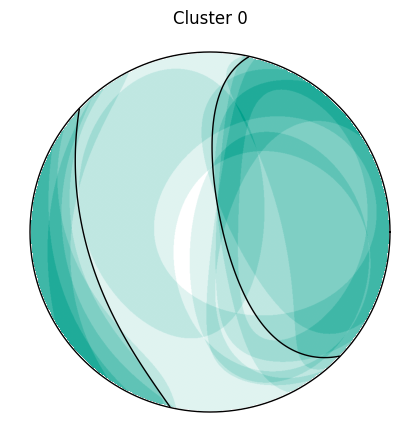

In [11]:
for i,key in enumerate(cls):
    fig = plt.figure(figsize=(4., 4.))
    fig.subplots_adjust(left=0., right=1., bottom=0., top=1.)
    axes = fig.add_subplot(1, 1, 1)

    plot_kwargs = {
        'beachball_type': 'full',
        'size': 9,
        'position': (5, 5),
        'color_t': cls_color[key][0], #'grey',
        'color_p':'white',
        'edgecolor': 'black',
        'best_color':'black',
        'linewidth':1, 
        'grid_resolution':800
        }
    
    beachball.plot_fuzzy_beachball_mpl_pixmap(cls[key], axes,best_mt=cat_kagan[i].moment_tensor, **plot_kwargs)

    # only kagan MT
    #beachball.plot_fuzzy_beachball_mpl_pixmap([cat_kagan[i].moment_tensor], axes,best_mt=cat_kagan[i].moment_tensor, **plot_kwargs)

    # Decorate the axes
    axes.set_xlim(0., 10.)
    axes.set_ylim(0., 10.)
    axes.set_axis_off()
    axes.set_title(f'Cluster {key}')
    
    # save fig
    #fig.savefig(f'../PLOTS/FUZZY_MT/fuzzy_mt_cluster_{key}.pdf')
    # only kagan
    #fig.savefig(f'../PLOTS/FUZZY_MT/kagan_mt_cluster_{key}.pdf')

plt.show()

# VLP tension and pression angles

In [33]:
# using all solution
cat_filename=os.path.join(catdir,'catalogue_flegrei_MT_final_VLP_reloc.pf')

cat=model.load_events(cat_filename)

tension_pression_ev = {ev.name: 'T' for ev in cat}
# manually reviewed
tension_pression_ev['flegrei_2018_09_18_21_36_41']='P'
tension_pression_ev['flegrei_2023_09_07_17_45_28']='P'
tension_pression_ev['flegrei_2023_10_02_20_08_26']='P'
tension_pression_ev['flegrei_2024_06_08_01_52_04']='P'
tension_pression_ev['flegrei_2024_08_30_19_23_15']='P'

takeoff=[]
azimuth=[]
for ev in cat:
    print(f'\nevent: {ev.name}')
    mt=ev.moment_tensor

    if tension_pression_ev[ev.name]=='T':
        t_vector=mt.t_axis()
        print('Tension')
    elif tension_pression_ev[ev.name]=='P' :
        t_vector=mt.p_axis()
        print('Pression')
    else:
        print('ERROR: no valid T or P')
    #print(f'vector : {t_vector} (nord, east, down)')

    # Output coordinate system has coordinates radial, takeoff angle [deg] (downward is zero), and azimuth [deg] (northward is zero).
    t_angle=pmt.ned_to_rta(t_vector)
    t=t_angle[1]
    a=t_angle[2]
    if t>90.:
        t = 180 - t
        a = a + 180
    takeoff.append(t)
    azimuth.append(a)
    print(f'angles : {t} takeoff, {a} azimuth')
    
    #decomposition=mt.standard_decomposition()
    #(moment_iso, ratio_iso, m_iso)=decomposition[0]
    #(moment_dc, ratio_dc, m_dc)=decomposition[1]
    #(moment_clvd, ratio_clvd, m_clvd)=decomposition[2]
    #(moment_devi, ratio_devi, m_devi)=decomposition[3]





event: flegrei_2018_09_18_21_36_41
Pression
angles : 33.812185763930074 takeoff, 114.57405927721253 azimuth

event: flegrei_2023_06_11_06_44_25
Tension
angles : 59.06487529238875 takeoff, 89.5430998922938 azimuth

event: flegrei_2023_09_07_17_45_28
Pression
angles : 29.09627936003327 takeoff, 75.28999637374663 azimuth

event: flegrei_2023_09_26_07_10_29
Tension
angles : 58.30837744808821 takeoff, 86.09541284332401 azimuth

event: flegrei_2023_10_02_20_08_26
Pression
angles : 53.58793220221404 takeoff, 101.63540822949231 azimuth

event: flegrei_2024_04_27_03_44_56
Tension
angles : 58.87624538798336 takeoff, 76.3986096038162 azimuth

event: flegrei_2024_05_22_06_28_00
Tension
angles : 64.1442130316184 takeoff, 74.06469960204564 azimuth

event: flegrei_2024_06_08_01_52_04
Pression
angles : 74.277987021052 takeoff, 78.59311751918733 azimuth

event: flegrei_2024_06_18_01_58_24
Tension
angles : 71.12332218503936 takeoff, 75.21918325941273 azimuth

event: flegrei_2024_07_26_11_46_21
Tension


In [35]:
# using best solutions
cat_filename=os.path.join(catdir,'catalogue_flegrei_MT_final_VLP_reloc.pf')

cat=model.load_events(cat_filename)

tension_pression_ev = {ev.name: 'T' for ev in cat}
# manually reviewed T and P
tension_pression_ev['flegrei_2018_09_18_21_36_41']='P'
tension_pression_ev['flegrei_2023_09_07_17_45_28']='P'
tension_pression_ev['flegrei_2023_10_02_20_08_26']='P'
tension_pression_ev['flegrei_2024_06_08_01_52_04']='P'
tension_pression_ev['flegrei_2024_08_30_19_23_15']='P'

# manually excluded
tension_pression_ev['flegrei_2018_09_18_21_36_41']='X'
tension_pression_ev['flegrei_2023_06_11_06_44_25']='X' #maybe
tension_pression_ev['flegrei_2023_09_07_17_45_28']='X'
tension_pression_ev['flegrei_2024_06_08_01_52_04']='X'
tension_pression_ev['flegrei_2024_08_30_19_23_15']='X'
tension_pression_ev['flegrei_2025_02_16_14_30_02']='X'


takeoff=[]
azimuth=[]
for ev in cat:
    if tension_pression_ev[ev.name] != 'X': 
        print(f'\nevent: {ev.name}')
        mt=ev.moment_tensor

        if tension_pression_ev[ev.name]=='T':
            t_vector=mt.t_axis()
            print('Tension')
        elif tension_pression_ev[ev.name]=='P' :
            t_vector=mt.p_axis()
            print('Pression')
        else:
            print('ERROR: no valid T or P')
        #print(f'vector : {t_vector} (nord, east, down)')

        # Output coordinate system has coordinates radial, takeoff angle [deg] (downward is zero), and azimuth [deg] (northward is zero).
        t_angle=pmt.ned_to_rta(t_vector)
        t=t_angle[1]
        a=t_angle[2]
        if t>90.:
            t = 180 - t
            a = a + 180
        takeoff.append(t)
        azimuth.append(a)
        print(f'angles : {t} takeoff, {a} azimuth')

        #decomposition=mt.standard_decomposition()
        #(moment_iso, ratio_iso, m_iso)=decomposition[0]
        #(moment_dc, ratio_dc, m_dc)=decomposition[1]
        #(moment_clvd, ratio_clvd, m_clvd)=decomposition[2]
        #(moment_devi, ratio_devi, m_devi)=decomposition[3]



event: flegrei_2023_09_26_07_10_29
Tension
angles : 58.30837744808821 takeoff, 86.09541284332401 azimuth

event: flegrei_2023_10_02_20_08_26
Pression
angles : 53.58793220221404 takeoff, 101.63540822949231 azimuth

event: flegrei_2024_04_27_03_44_56
Tension
angles : 58.87624538798336 takeoff, 76.3986096038162 azimuth

event: flegrei_2024_05_22_06_28_00
Tension
angles : 64.1442130316184 takeoff, 74.06469960204564 azimuth

event: flegrei_2024_06_18_01_58_24
Tension
angles : 71.12332218503936 takeoff, 75.21918325941273 azimuth

event: flegrei_2024_07_26_11_46_21
Tension
angles : 55.83489764334233 takeoff, 69.01950726978811 azimuth


In [ ]:
# check angle for T and P axis
for ev in cat:
    print(f'\nevent: {ev.name}')
    mt=ev.moment_tensor

    if tension_pression_ev[ev.name]=='T':
        print('Selected: TENSION')
    else:
        print('Selected: PRESSION')
    t_vector=mt.t_axis()
    t_angle=pmt.ned_to_rta(t_vector)
    print(f'Tension angles : {t_angle} (radial, takeoff, azimuth)')

    t_vector=mt.p_axis()
    t_angle=pmt.ned_to_rta(t_vector)
    print(f'Pression angles : {t_angle} (radial, takeoff, azimuth)')


event: flegrei_2018_09_18_21_36_41
Selected: PRESSION
Tension angles : [  1.         107.65529148  52.9479959 ] (radial, takeoff, azimuth)
Pression angles : [  1.         146.18781424 -65.42594072] (radial, takeoff, azimuth)

event: flegrei_2023_06_11_06_44_25
Selected: TENSION
Tension angles : [  1.         120.93512471 -90.45690011] (radial, takeoff, azimuth)
Pression angles : [   1.           35.45741459 -123.15392754] (radial, takeoff, azimuth)

event: flegrei_2023_09_07_17_45_28
Selected: PRESSION
Tension angles : [  1.          90.80605835 163.84132411] (radial, takeoff, azimuth)
Pression angles : [ 1.         29.09627936 75.28999637] (radial, takeoff, azimuth)

event: flegrei_2023_09_26_07_10_29
Selected: TENSION
Tension angles : [  1.         121.69162255 -93.90458716] (radial, takeoff, azimuth)
Pression angles : [  1.          38.24566642 -55.46862987] (radial, takeoff, azimuth)

event: flegrei_2023_10_02_20_08_26
Selected: PRESSION
Tension angles : [  1.         142.61825609

In [36]:
mean_takeoff=np.mean(takeoff)
std_takeoff=np.std(takeoff)
print(f'mean takeoff (down is 0) : {mean_takeoff} +- {std_takeoff}')

mean_azimuth=np.mean(azimuth)
std_azimuth=np.std(azimuth)
print(f'mean azimuth (nord is 0) : {mean_azimuth} +- {std_azimuth}')

mean takeoff (down is 0) : 60.312497983047614 +- 5.8152668399391585
mean azimuth (nord is 0) : 80.40547013464649 +- 10.769430066255437


# Percentage of DC component

In [43]:
cat_filename=os.path.join(catdir,'catalogue_flegrei_MT_final.pf')

cat=model.load_events(cat_filename)

nonDC=[]
count_ev=0
percentage=50
mag=[]
for ev in cat:
    decomposition=ev.moment_tensor.standard_decomposition()
    (moment_iso, ratio_iso, m_iso)=decomposition[0]
    (moment_dc, ratio_dc, m_dc)=decomposition[1]
    (moment_clvd, ratio_clvd, m_clvd)=decomposition[2]
    (moment_devi, ratio_devi, m_devi)=decomposition[3]

    #print(f'iso: {ratio_iso*100:3.3}% , dc: {ratio_dc*100:3.3}% , clvd: {ratio_clvd*100:3.3}% total: {((ratio_iso+ratio_dc+ratio_clvd)*100):4.4}')
    #print(f'devi: {ratio_devi*100:4.4}% --- non DC pecentage= {(1-ratio_dc)*100:3.3}%\n')
    
    nonDC.append((1-ratio_dc)*100)
    if (ratio_clvd)*100>percentage:
        count_ev+=1
        print(f'{ev.name} --- non DC : {(1-ratio_dc)*100:3.3}% --- CLVD : {ratio_clvd*100:3.3}%')
print(f'total events with non CD component>{percentage}  = {count_ev}')


mean_nonDC=np.mean(nonDC)
std_nonDC=np.std(nonDC)
max_nonDC=np.max(nonDC)
min_nonDC=np.min(nonDC)

print(f'\nmean non DC: {mean_nonDC:3.4} +- {std_nonDC:3.4}')
print(f'max non DC: {max_nonDC:3.4} min non DC: {min_nonDC:3.4}')

flegrei_2019_12_06_00_17_23 --- non DC : 54.4% --- CLVD : 54.4%
flegrei_2022_03_29_17_45_32 --- non DC : 79.8% --- CLVD : 79.8%
flegrei_2023_02_05_00_45_36 --- non DC : 64.5% --- CLVD : 64.5%
flegrei_2023_05_08_02_28_34 --- non DC : 65.2% --- CLVD : 65.2%
flegrei_2023_09_12_02_28_50 --- non DC : 53.3% --- CLVD : 53.3%
flegrei_2023_09_26_07_10_29 --- non DC : 56.1% --- CLVD : 56.1%
flegrei_2023_10_04_08_46_55 --- non DC : 60.1% --- CLVD : 60.1%
flegrei_2023_11_23_18_41_46 --- non DC : 92.9% --- CLVD : 92.9%
flegrei_2024_02_17_18_09_50 --- non DC : 69.0% --- CLVD : 69.0%
flegrei_2024_04_04_05_14_36 --- non DC : 58.6% --- CLVD : 58.6%
flegrei_2024_04_14_07_57_58 --- non DC : 60.3% --- CLVD : 60.3%
flegrei_2024_04_14_08_01_43 --- non DC : 69.2% --- CLVD : 69.2%
flegrei_2024_04_27_03_44_56 --- non DC : 51.7% --- CLVD : 51.7%
flegrei_2024_05_20_19_55_37 --- non DC : 79.9% --- CLVD : 79.9%
flegrei_2024_05_22_06_28_00 --- non DC : 53.8% --- CLVD : 53.8%
flegrei_2024_05_25_01_03_23 --- non DC :

In [44]:
cat_filename=os.path.join(catdir,'catalogue_flegrei_MT_final_FULL.pf')
cat=model.load_events(cat_filename)

nonDC=[]
count_ev=0
percentage=50
mag=[]
for ev in cat:
    decomposition=ev.moment_tensor.standard_decomposition()
    (moment_iso, ratio_iso, m_iso)=decomposition[0]
    (moment_dc, ratio_dc, m_dc)=decomposition[1]
    (moment_clvd, ratio_clvd, m_clvd)=decomposition[2]
    (moment_devi, ratio_devi, m_devi)=decomposition[3]

    #print(f'iso: {ratio_iso*100:3.3}% , dc: {ratio_dc*100:3.3}% , clvd: {ratio_clvd*100:3.3}% total: {((ratio_iso+ratio_dc+ratio_clvd)*100):4.4}')
    #print(f'devi: {ratio_devi*100:4.4}% --- non DC pecentage= {(1-ratio_dc)*100:3.3}%\n')
    
    nonDC.append((1-ratio_dc)*100)
    if (ratio_clvd)*100>percentage:
        count_ev+=1
        print(f'{ev.name} --- non DC : {(1-ratio_dc)*100:3.3}% --- ISO : {ratio_iso*100:3.3}%  --- CLVD (difference) : {ratio_clvd*100:3.3}%')
print(f'total events with CLVD component>{percentage}  = {count_ev}')


mean_nonDC=np.mean(nonDC)
std_nonDC=np.std(nonDC)
max_nonDC=np.max(nonDC)
min_nonDC=np.min(nonDC)

print(f'\nmean non DC: {mean_nonDC:3.4} +- {std_nonDC:3.4}')
print(f'max non DC: {max_nonDC:3.4} min non DC: {min_nonDC:3.4}')

flegrei_2019_12_06_00_17_23 --- non DC : 88.2% --- ISO : 0.577%  --- CLVD (difference) : 87.6%
flegrei_2023_01_19_08_44_30 --- non DC : 86.5% --- ISO : 30.2%  --- CLVD (difference) : 56.3%
flegrei_2023_03_04_13_15_20 --- non DC : 89.2% --- ISO : 35.5%  --- CLVD (difference) : 53.7%
flegrei_2023_04_23_00_35_20 --- non DC : 81.1% --- ISO : 19.7%  --- CLVD (difference) : 61.5%
flegrei_2023_05_08_02_28_34 --- non DC : 83.3% --- ISO : 23.5%  --- CLVD (difference) : 59.8%
flegrei_2023_05_08_22_33_17 --- non DC : 72.6% --- ISO : 11.9%  --- CLVD (difference) : 60.6%
flegrei_2023_10_04_08_46_55 --- non DC : 64.7% --- ISO : 5.05%  --- CLVD (difference) : 59.6%
flegrei_2023_10_16_10_36_21 --- non DC : 58.7% --- ISO : 1.06%  --- CLVD (difference) : 57.6%
flegrei_2024_02_17_18_09_50 --- non DC : 80.3% --- ISO : 21.4%  --- CLVD (difference) : 58.9%
flegrei_2024_03_03_09_01_59 --- non DC : 77.5% --- ISO : 23.1%  --- CLVD (difference) : 54.4%
flegrei_2024_04_14_07_57_58 --- non DC : 87.7% --- ISO : 23

# Catalogue with deviatoric components of the FULL inversions

In [45]:
from pyrocko import moment_tensor, orthodrome
cat_filename=os.path.join(catdir,'catalogue_flegrei_MT_final_FULL.pf')
cat=model.load_events(cat_filename)

nonDC=[]
count_ev=0
percentage=50
mag=[]
for ev in cat:
    decomposition=ev.moment_tensor.standard_decomposition()
    #(moment_iso, ratio_iso, m_iso)=decomposition[0]
    #(moment_dc, ratio_dc, m_dc)=decomposition[1]
    #(moment_clvd, ratio_clvd, m_clvd)=decomposition[2]
    (moment_devi, ratio_devi, m_devi)=decomposition[3]
    #print(ev.moment_tensor.__dict__)
    mtdevi=moment_tensor.MomentTensor(m_devi)
    ev.moment_tensor = mtdevi
    #print(ev.moment_tensor.__dict__ ,'\n')

cat_filename_devi=os.path.join(catdir,'catalogue_flegrei_MT_final_FULL_devi.pf')
model.dump_events(cat, cat_filename_devi)
